# <center> 🌿 Organic Vs ♻️ Recyclable Waste Classification </center>

In this notebook we will deal with a dataset containing 25,000 images of waste. Our task is to build a model to classify this waste into organic waste and recyclable waste. We will experiment with CNN classifiers in order to achieve this task

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from PIL import Image

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision.io import read_image
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader

## Parse Data directories

In [2]:
def get_img_paths(path):
    paths = []
    labels = []
    for label in os.listdir(path):
        img_dir = os.path.join(path, label)
        for img in os.listdir(img_dir):
            paths.append(os.path.join(img_dir, img))
            labels.append(label)

    return pd.DataFrame({'path':paths, 'label':labels})

## Training Paths

In [3]:
train = get_img_paths("../input/waste-classification-data/DATASET/TRAIN")
train.head()

,path,label
0,../input/waste-classification-data/DATASET/TRA...,R
1,../input/waste-classification-data/DATASET/TRA...,R
2,../input/waste-classification-data/DATASET/TRA...,R
3,../input/waste-classification-data/DATASET/TRA...,R
4,../input/waste-classification-data/DATASET/TRA...,R


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22564 entries, 0 to 22563
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    22564 non-null  object
 1   label   22564 non-null  object
dtypes: object(2)
memory usage: 352.7+ KB


## Test Paths

In [5]:
test = get_img_paths("../input/waste-classification-data/DATASET/TEST")
test.head()

,path,label
0,../input/waste-classification-data/DATASET/TES...,R
1,../input/waste-classification-data/DATASET/TES...,R
2,../input/waste-classification-data/DATASET/TES...,R
3,../input/waste-classification-data/DATASET/TES...,R
4,../input/waste-classification-data/DATASET/TES...,R


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2513 entries, 0 to 2512
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    2513 non-null   object
 1   label   2513 non-null   object
dtypes: object(2)
memory usage: 39.4+ KB


## Label Encoding

In [7]:
conversion = {'O': 0, 'R': 1}

train.label = train.label.map(conversion)
test.label = test.label.map(conversion)

train.head()

,path,label
0,../input/waste-classification-data/DATASET/TRA...,1
1,../input/waste-classification-data/DATASET/TRA...,1
2,../input/waste-classification-data/DATASET/TRA...,1
3,../input/waste-classification-data/DATASET/TRA...,1
4,../input/waste-classification-data/DATASET/TRA...,1


## Dataset Generator

In [8]:
class WasteData(Dataset):
    def __init__(self, dir_lbl, transform=None):
        self.dir_lbl = dir_lbl
        self.transform = transform

    def __len__(self):
        return len(self.dir_lbl)

    def __getitem__(self, idx):
        img_dir_lbl = self.dir_lbl.iloc[idx]
        img_dir = img_dir_lbl.path
        label = img_dir_lbl.label
        image = Image.open(img_dir).convert('RGB')
        
        if self.transform:
            image = self.transform(image)

        return image, label

In [9]:
data_transform = transforms.Compose([
    transforms.Resize((256)),
    transforms.ToTensor(),
    transforms.CenterCrop(224),
    transforms.Normalize(
           mean=[0.485, 0.456, 0.406],
           std=[0.229, 0.224, 0.225])
])

In [10]:
train_dataset = WasteData(train, data_transform)
train_dataset

train_size = int(0.9 * len(train_dataset))
valid_size = len(train_dataset) - train_size
train_dataset, valid_dataset = torch.utils.data.random_split(train_dataset, [train_size, valid_size])

In [11]:
test_dataset = WasteData(test, data_transform)
test_dataset

In [12]:
batch_size = 64

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

## Display Preprocessed Image Sample

Label 1: 1


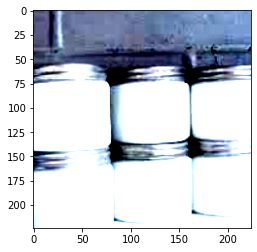

Label 2: 0


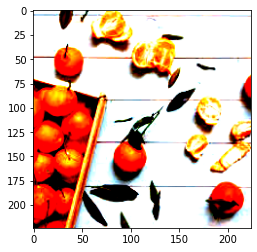

Label 3: 1


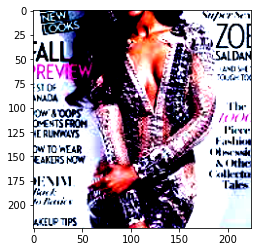

Label 4: 0


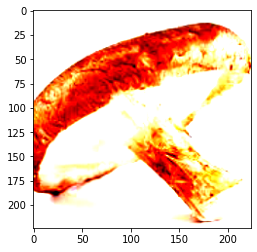

Label 5: 0


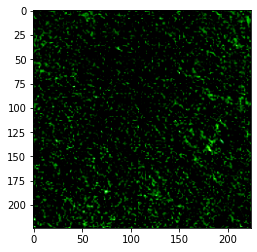

In [13]:
for i in range(5):
    train_features, train_labels = next(iter(train_dataloader))
    img = train_features[0].squeeze().numpy().transpose((1, 2, 0))

    label = train_labels[0]
    print(f"Label {i+1}: {label}")
    plt.imshow(img)
    plt.show()

## Enable GPU

In [14]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

cuda:0


## Construct Model

In [15]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 8, 3)
        self.conv2 = nn.Conv2d(8, 16, 3)
        self.pool = nn.MaxPool2d(2, 2)
        
        self.conv3 = nn.Conv2d(16, 32, 3)
        self.conv4 = nn.Conv2d(32, 32, 3)
    
        self.conv5 = nn.Conv2d(32, 64, 3)
        self.conv6 = nn.Conv2d(64, 64, 3)
            
        self.fc1 = nn.Linear(64*24*24, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 10)
        self.fc4 = nn.Linear(10, 1)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        
        x = F.relu(self.conv3(x))
        x = self.pool(F.relu(self.conv4(x)))
        
        x = F.relu(self.conv5(x))
        x = self.pool(F.relu(self.conv6(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        return x
    
net = Net().to(device)

In [16]:
import torch.optim as optim

criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=0.0005)

## Training

We will use early stopping to get the best validation errors. this happens in 4 epochs

In [17]:
train_loss = []
val_loss = []
epochs = 4
for epoch in range(epochs): 
    epoch_loss = 0.0
    epoch_loss_val = 0.0
    running_loss = 0.0
    print('Training:')
    for i, data in enumerate(train_dataloader, 0):
        inputs, labels = data[0].to(device), data[1].float().to(device)

        optimizer.zero_grad()

        outputs = net(inputs).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 10 == 9:
            loss = running_loss / 10
            epoch_loss += loss
            print(f'\t[{epoch + 1}, {i + 1:5d}] loss: {loss:.6f}')
            running_loss = 0.0
     
    print('Validation:')
    running_loss_valid = 0.0
    for i, data in enumerate(valid_dataloader, 0):
        with torch.no_grad():
            inputs, labels = data[0].to(device), data[1].float().to(device)

            outputs = net(inputs).squeeze()
            loss = criterion(outputs, labels)

            running_loss_valid += loss.item()
            if i % 10 == 9:
                loss = running_loss_valid / 10
                epoch_loss_val += loss
                print(f'\t[{epoch + 1}, {i + 1:5d}] loss: {loss:.6f}')
                running_loss_valid = 0.0
                
    train_loss.append(epoch_loss)
    val_loss.append(epoch_loss_val)

print('Finished Training and Validation')

Training:
	[1,    10] loss: 0.682511
	[1,    20] loss: 0.633482
	[1,    30] loss: 0.573621
	[1,    40] loss: 0.558763
	[1,    50] loss: 0.482939
	[1,    60] loss: 0.460370
	[1,    70] loss: 0.466562
	[1,    80] loss: 0.448828
	[1,    90] loss: 0.449003
	[1,   100] loss: 0.443335
	[1,   110] loss: 0.441176
	[1,   120] loss: 0.453387
	[1,   130] loss: 0.435944
	[1,   140] loss: 0.445761
	[1,   150] loss: 0.463815
	[1,   160] loss: 0.417758
	[1,   170] loss: 0.440278
	[1,   180] loss: 0.411261
	[1,   190] loss: 0.373117
	[1,   200] loss: 0.380944
	[1,   210] loss: 0.378813
	[1,   220] loss: 0.387873
	[1,   230] loss: 0.491367
	[1,   240] loss: 0.441570
	[1,   250] loss: 0.445317
	[1,   260] loss: 0.445083
	[1,   270] loss: 0.427153
	[1,   280] loss: 0.427086
	[1,   290] loss: 0.451860
	[1,   300] loss: 0.388359
	[1,   310] loss: 0.391268
Validation:
	[1,    10] loss: 0.434341
	[1,    20] loss: 0.437102
	[1,    30] loss: 0.472912
Training:
	[2,    10] loss: 0.382384
	[2,    20] loss: 0.426

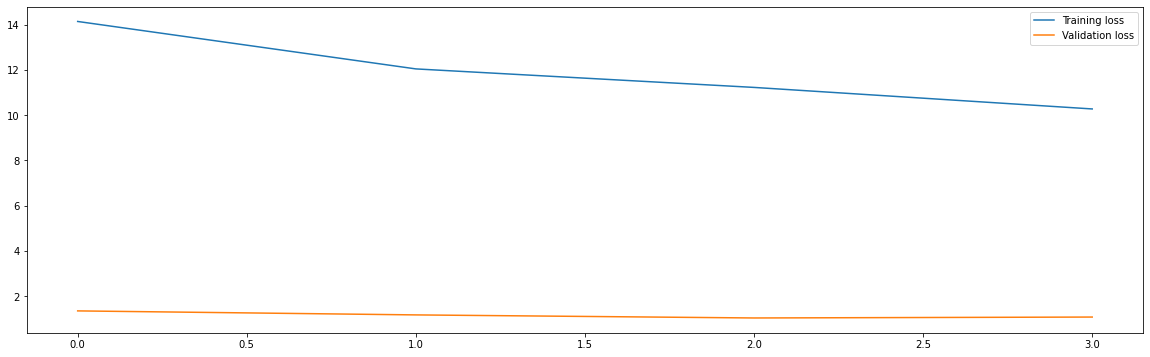

In [18]:
plt.figure(figsize=(20,6));
sns.lineplot(x=list(range(epochs)), y=train_loss)
sns.lineplot(x=list(range(epochs)), y=val_loss)
plt.legend(['Training loss', 'Validation loss']) 

## Testing

In [19]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data[0].to(device), data[1].float().to(device)
        outputs = net(images)
        predicted = torch.round(outputs.data).squeeze()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the {total} test images: {100 * correct // total} %')

Accuracy of the network on the 2513 test images: 86 %
